<a href="https://colab.research.google.com/github/eysaritas/Diabetes-Prediction-System-/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------------------------
PARA TİPİ  | ALAN (AREA)     | RENK
---------------------------------------------
1 TL       | 17446           | sari
25 Kr      | 16920           | gumus
1 TL       | 11275           | sari
1 TL       | 10922           | sari
---------------------------------------------
TOPLAM PARA: 3.25 TL


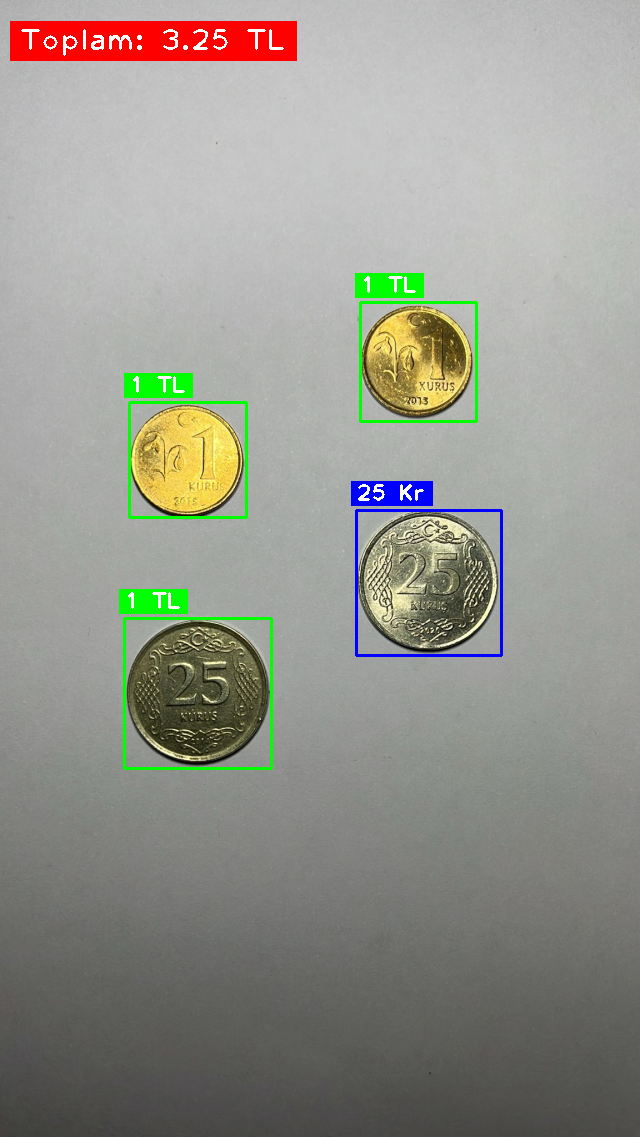

In [ ]:
# --- 1. KURULUM VE KÜTÜPHANELER ---
!pip install cvzone

import cv2
import cvzone
import numpy as np
from google.colab.patches import cv2_imshow
import os

# --- 2. AYARLAR VE FONKSİYONLAR ---

path = 'ornek4.jpeg'

if not os.path.exists(path):
    print(f"HATA: '{path}' dosyası bulunamadı! Lütfen sol menüdeki klasör simgesine tıklayıp fotoğrafı yükleyin.")
else:
    # Resmi oku ve standart boyuta getir (640px genişlik)
    img_original = cv2.imread(path)
    base_width = 640
    ratio = base_width / img_original.shape[1]
    dim = (base_width, int(img_original.shape[0] * ratio))
    img = cv2.resize(img_original, dim, interpolation=cv2.INTER_AREA)

    def preProcessing(img):
        imgPre = cv2.GaussianBlur(img, (5, 5), 3)
        thresh1 = 50
        thresh2 = 150
        imgPre = cv2.Canny(imgPre, thresh1, thresh2)
        kernel = np.ones((3, 3), np.uint8)
        imgPre = cv2.dilate(imgPre, kernel, iterations=2)
        imgPre = cv2.morphologyEx(imgPre, cv2.MORPH_CLOSE, kernel)
        return imgPre

    def getColorCategory(imgCrop):
        """
        Paranın rengini analiz eder: Gümüş, Bakır veya Sarı
        HSV değerleri bu resim için optimize edilmiştir.
        """
        imgHSV = cv2.cvtColor(imgCrop, cv2.COLOR_BGR2HSV)
        h, w, _ = imgHSV.shape
        center_region = imgHSV[int(h/4):int(h*3/4), int(w/4):int(w*3/4)]

        avg_color_per_row = np.average(center_region, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)

        hue = avg_color[0]
        saturation = avg_color[1]

        # --- GÜNCELLENMİŞ RENK MANTIĞI ---
        # Gümüş (25 Kr): Doygunluk biraz daha yüksek olabilir ama Hue genelde nötrdür.
        # Eşiği 60'a çıkardık.
        if saturation < 60:
            return "gumus"

        # Bakır (1 Kr): Kırmızıya çok yakın tonlar ve yüksek doygunluk
        if (hue < 20 or hue > 160) and saturation > 50:
            return "bakir"

        # Diğerleri (Sarı - 1TL, 50Kr, 10Kr, 5Kr)
        return "sari"

    # --- 3. ANA İŞLEM ---

    imgPre = preProcessing(img)
    # Küçük gürültüleri almamak için minArea'yı artırdık.
    imgContours, conFound = cvzone.findContours(img, imgPre, minArea=1500)

    totalMoney = 0.0

    if conFound:
        print(f"{'-'*45}")
        print(f"{'PARA TİPİ':<10} | {'ALAN (AREA)':<15} | {'RENK'}")
        print(f"{'-'*45}")

        for count, contour in enumerate(conFound):
            area = contour['area']
            x, y, w, h = contour['bbox']

            imgCrop = img[y:y + h, x:x + w]
            colorType = getColorCategory(imgCrop)

            currentVal = 0.0
            label = ""
            color_box = (0, 255, 0) # Varsayılan Yeşil

            # --- GÜNCELLENMİŞ SINIFLANDIRMA MANTIĞI ---
            # 640px genişlikteki resim baz alınarak alanlar kalibre edildi.

            if colorType == "gumus":
                currentVal = 0.25
                label = "25 Kr"
                color_box = (255, 0, 0) # Mavi

            elif colorType == "bakir":
                currentVal = 0.01
                label = "1 Kr"
                color_box = (0, 165, 255) # Turuncu

            else: # SARI PARALAR (Boyuta göre kesin ayrım)
                # Bu alan değerleri gönderdiğin resimdeki paraların
                # 640px'e oranlanmış hallerine göre ayarlandı.
                if area > 6200:
                    currentVal = 1.0
                    label = "1 TL"
                elif 5000 < area <= 6200:
                    currentVal = 0.50
                    label = "50 Kr"
                elif 4000 < area <= 5000:
                    currentVal = 0.10
                    label = "10 Kr"
                elif 2000 < area <= 4000:
                    currentVal = 0.05
                    label = "5 Kr"
                else:
                    label = "Bilinmiyor" # Çok küçük sarı nesne

            if currentVal > 0:
                totalMoney += currentVal

            # Ekrana Çizdir
            cvzone.putTextRect(img, label, (x, y - 10), scale=1.5, thickness=2, offset=5, colorR=color_box)
            cv2.rectangle(img, (x, y), (x + w, y + h), color_box, 2)

            print(f"{label:<10} | {int(area):<15} | {colorType}")

    # --- 4. SONUÇLARI GÖSTERME ---
    print(f"{'-'*45}")
    print(f"TOPLAM PARA: {totalMoney:.2f} TL")

    # Ekrana sonucu yaz
    cvzone.putTextRect(img, f'Toplam: {totalMoney:.2f} TL', (20, 50), scale=2, thickness=2, colorR=(0,0,255))

    # Colab'da sonucu göster
    cv2_imshow(img)

Referans havuzu taranıyor...
-> Eklendi: ref_50kr_c.jpg (0.5 TL)
-> Eklendi: ref_1tl_d.jpg (1.0 TL)
-> Eklendi: ref_1kr_d.jpg (0.01 TL)
-> Eklendi: ref_1kr_b.jpg (0.01 TL)
-> Eklendi: ref_1tl_f.jpg (1.0 TL)
-> Eklendi: ref_5kr_a.jpg (0.05 TL)
-> Eklendi: ref_1tl_h.jpg (1.0 TL)
-> Eklendi: ref_1kr_g.jpg (0.01 TL)
-> Eklendi: ref_25kr_i.jpg (0.25 TL)
-> Eklendi: ref_1tl_g.jpg (1.0 TL)
-> Eklendi: ref_10kr_e.jpg (0.1 TL)
-> Eklendi: ref_25kr_c.jpg (0.25 TL)
-> Eklendi: ref_1kr_c.jpg (0.01 TL)
-> Eklendi: ref_10kr_d.jpg (0.1 TL)
-> Eklendi: ref_25kr_b.jpg (0.25 TL)
-> Eklendi: ref_25kr_g.jpg (0.25 TL)
-> Eklendi: ref_10kr_a.jpg (0.1 TL)
-> Eklendi: ref_1kr_a.jpg (0.01 TL)
-> Eklendi: ref_10kr_c.jpg (0.1 TL)
-> Eklendi: ref_50kr_i.jpg (0.5 TL)
-> Eklendi: ref_1kr_e.jpg (0.01 TL)
-> Eklendi: ref_1tl_b.jpg (1.0 TL)
-> Eklendi: ref_10kr_b.jpg (0.1 TL)
-> Eklendi: ref_50kr_f.jpg (0.5 TL)
-> Eklendi: ref_25kr_h.jpg (0.25 TL)
-> Eklendi: ref_1tl_c.jpg (1.0 TL)
-> Eklendi: ref_50kr_g.jpg (0.5 TL)


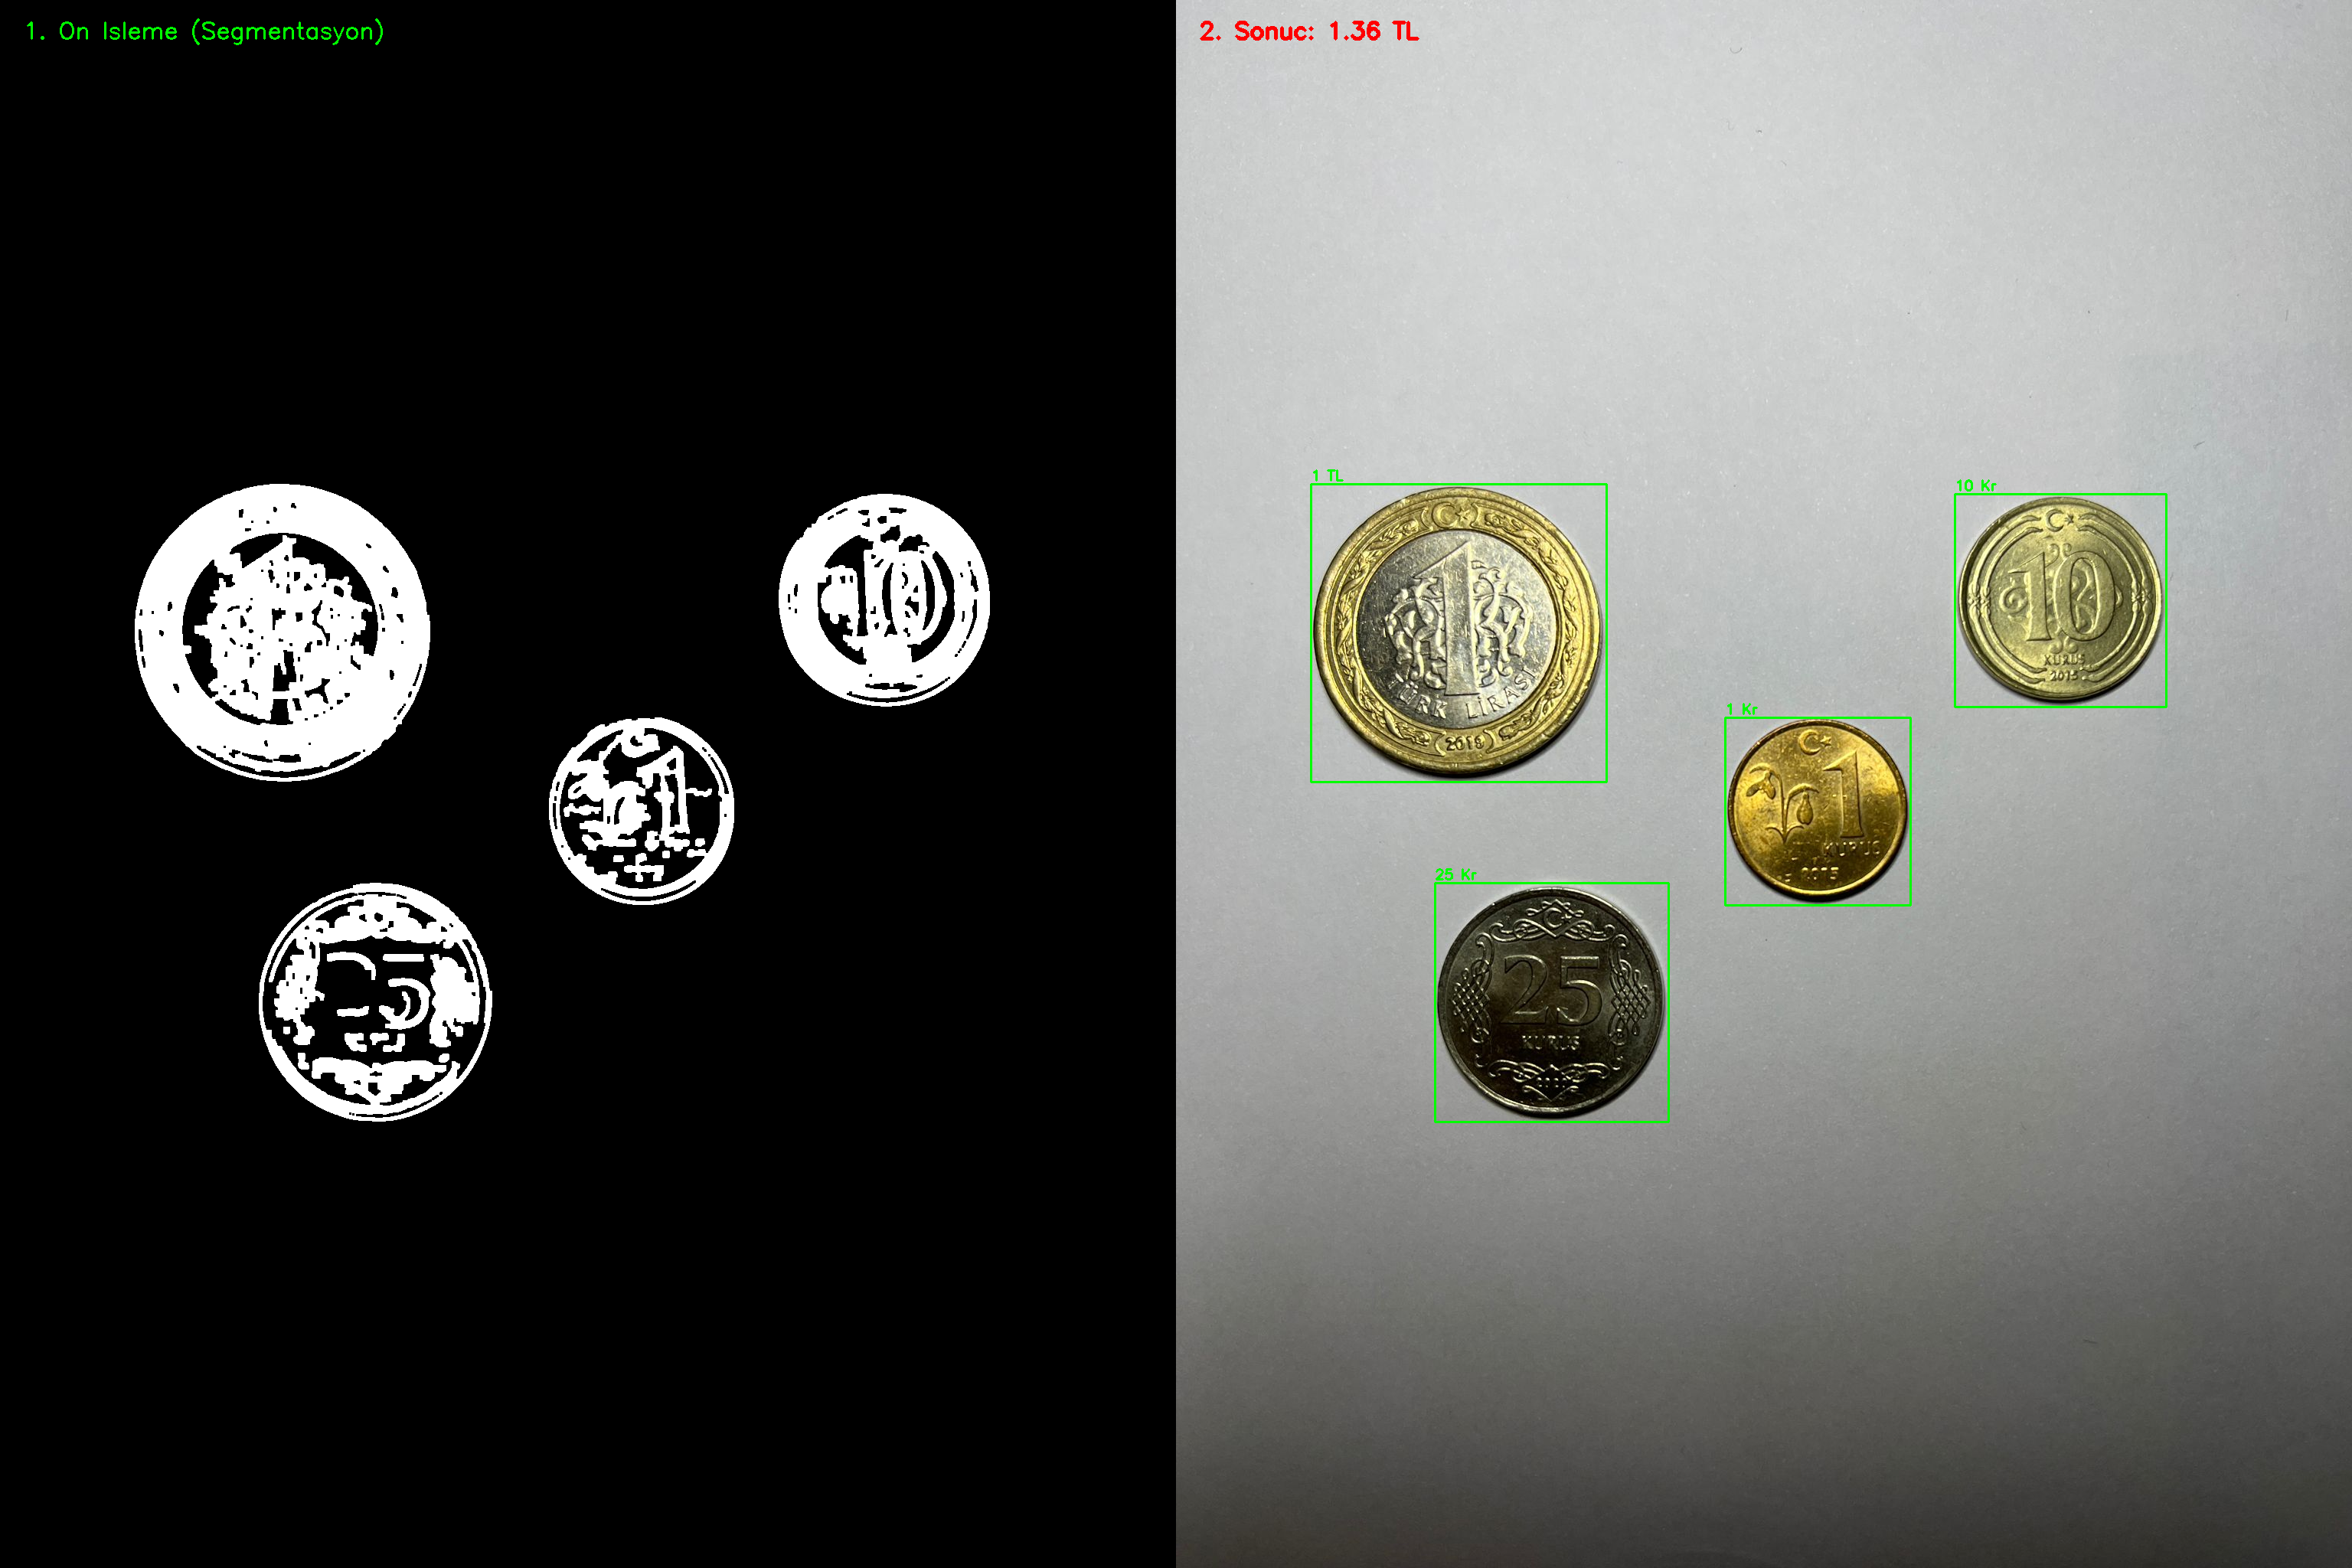

In [15]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# --- AYARLAR ---
TEST_IMAGE = "7.jpeg"  # Test edilecek görüntü
REF_DIR = "."         # Referansların olduğu klasör

def get_sift_features(img_bgr):
    """Görüntüden SIFT özelliklerini çıkarır."""
    if img_bgr is None: return None, None
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

def preProcessing(img):
    """Paraların yerini bulmak için ön işleme (Siyah-Beyaz Segmentasyon)"""
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 3)
    imgCanny = cv2.Canny(imgBlur, 30, 150)
    kernel = np.ones((3, 3), np.uint8)
    imgDilate = cv2.dilate(imgCanny, kernel, iterations=2)
    imgClosed = cv2.morphologyEx(imgDilate, cv2.MORPH_CLOSE, kernel)
    return imgClosed

def parse_value_from_filename(filename):
    """Dosya isminden para değerini anlar."""
    name = filename.lower()
    if "1tl" in name: return 1.00
    if "50kr" in name or "50krs" in name: return 0.50
    if "25kr" in name or "25krs" in name: return 0.25
    if "10kr" in name or "10krs" in name: return 0.10
    if "5kr" in name or "5krs" in name: return 0.05
    if "1kr" in name or "1krs" in name: return 0.01
    return 0.0

def main():
    # 1. REFERANSLARI YÜKLE
    print("Referans havuzu taranıyor...")
    reference_data = []

    files = [f for f in os.listdir(REF_DIR) if f.startswith("ref_") and (f.endswith(".jpg") or f.endswith(".png"))]

    for f in files:
        val = parse_value_from_filename(f)
        if val > 0:
            path = os.path.join(REF_DIR, f)
            img = cv2.imread(path)
            kp, des = get_sift_features(img)
            if des is not None:
                reference_data.append({"name": f, "value": val, "kp": kp, "des": des})
                print(f"-> Eklendi: {f} ({val} TL)")

    if not reference_data:
        print("HATA: Referans dosyaları bulunamadı! Lütfen yükleyin.")
        return

    # 2. HEDEF GÖRÜNTÜYÜ AÇ
    img = cv2.imread(TEST_IMAGE)
    if img is None:
        print(f"Hedef resim ({TEST_IMAGE}) bulunamadı.")
        return

    imgDisplay = img.copy()       # Sonuçları çizeceğimiz kopya
    imgPre = preProcessing(img)   # Siyah-beyaz işlem görüntüsü

    # 3. ANALİZ
    contours, _ = cv2.findContours(imgPre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    total_money = 0.0
    bf = cv2.BFMatcher()

    print(f"\nAnaliz ediliyor... ({len(contours)} nesne bulundu)")

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 800:
            x, y, w, h = cv2.boundingRect(cnt)
            imgCrop = img[y:y+h, x:x+w]
            kp_crop, des_crop = get_sift_features(imgCrop)

            if des_crop is None or len(kp_crop) < 5: continue

            best_match_val = 0
            max_good_matches = 0

            # Eşleştirme
            for ref in reference_data:
                matches = bf.knnMatch(des_crop, ref["des"], k=2)
                good_matches = []
                for m, n in matches:
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)

                if len(good_matches) > max_good_matches:
                    max_good_matches = len(good_matches)
                    best_match_val = ref["value"]

            # Sonuçları Çiz
            if max_good_matches >= 10:
                total_money += best_match_val
                cv2.rectangle(imgDisplay, (x, y), (x+w, y+h), (0, 255, 0), 2)

                label = f"{int(best_match_val*100)} Kr" if best_match_val < 1 else f"{int(best_match_val)} TL"
                cv2.putText(imgDisplay, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            else:
                cv2.rectangle(imgDisplay, (x, y), (x+w, y+h), (0, 0, 255), 2)

    # 4. GÖRSELLEŞTİRME (SPLIT SCREEN)

    # imgPre (Siyah Beyaz) görüntüyü Renkli formata çevir (hstack yapabilmek için)
    imgPre_BGR = cv2.cvtColor(imgPre, cv2.COLOR_GRAY2BGR)

    # Başlıkları Ekle
    cv2.putText(imgPre_BGR, "1. On Isleme (Segmentasyon)", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(imgDisplay, f"2. Sonuc: {total_money:.2f} TL", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    # İki görüntüyü yan yana birleştir (Horizontal Stack)
    # Eğer resim çok büyükse resize yapabiliriz, şu an orijinal boyutta birleştiriyoruz.
    stacked_img = np.hstack((imgPre_BGR, imgDisplay))

    print(f"\n--- HESAPLANAN TOPLAM TUTAR: {total_money:.2f} TL ---")
    print("Görselleştirme: Solda bilgisayarın sınırları algılayışı, Sağda tanımlama sonucu.")

    # Sonucu Göster
    cv2_imshow(stacked_img)

if __name__ == "__main__":
    main()